In [1]:
print("Hello")

Hello


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Читаем данные из порта USB в файл:

`cat /dev/cu.usbmodem1421 > output3.bin`

Они будут в бинарном формате, прочитаем их в DataFrame и сконвертируем в миллиамперы:

In [4]:
df = pd.DataFrame(np.fromfile("./output.bni", dtype=np.uint16).astype(np.float32) * (3300 / 2**12))
#df.describe()

Данных много, миллион сэмплов в секунду. Мы насобирали почти 70 миллионов сэмплов. Если строить их все сразу, питон ОЧЕНЬ задумается. Поэтому будем строить кусочки. 100 сэмплов, или 100 микросекунд:

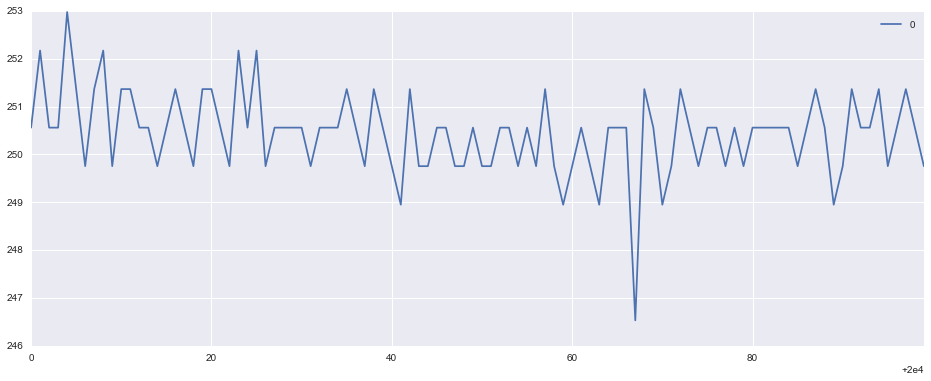

In [230]:
fig = sns.plt.figure(figsize=(16, 6))
ax = sns.plt.subplot()
df[20000:20100].plot(ax=ax)

Возьмем более мелкий масштаб, для этого сгруппируем данные по 10 мкс и возьмем среднее:


In [210]:
df_r = df.groupby(df.index//10).mean()

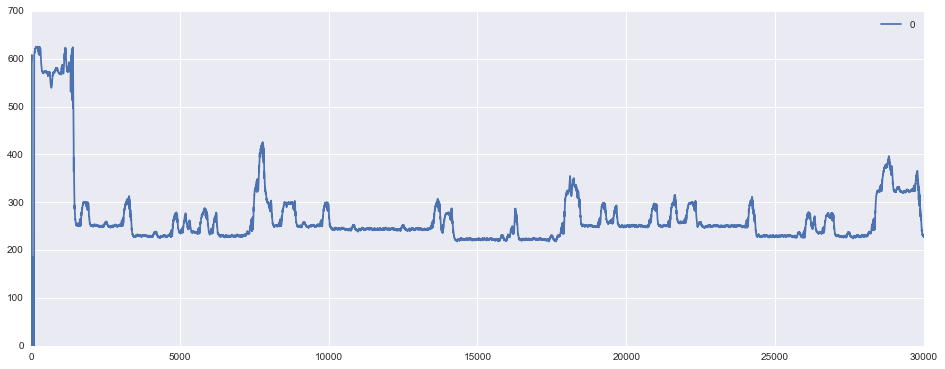

In [232]:
fig = sns.plt.figure(figsize=(16, 6))
ax = sns.plt.subplot()
df_r[:30000].plot(ax=ax)

Посмотрим на таймстемпы в logcat. У нас три события из Браузера, остальное -- включение/выключение фонарика.
```
05:05:51.540
05:05:52.010
05:05:52.502
05:05:52.857
05:05:53.317
05:05:53.660
05:05:54.118
05:05:54.504
05:05:54.966
05:05:55.270
05:06:01.916 14509 14509 I cr_Ya:DownloadTracking: PageLoadStarted, ElapsedRealtimeMillis: 1241509
05:06:03.453 14509 14509 I cr_Ya:DownloadTracking: DownloadStarted, ElapsedRealtimeMillis: 1243046
05:06:09.147 14509 14509 I cr_Ya:DownloadTracking: DownloadFinished, ElapsedRealtimeMillis: 1248740
05:06:13.336
05:06:13.691
05:06:14.051
05:06:14.377
05:06:14.783
05:06:15.089
05:10:32.190
05:10:34.015
05:10:37.349
05:10:37.491
```
Еще раз сделаем ресемплинг, чтобы в одной точке была одна миллисекунда и построим все данные:

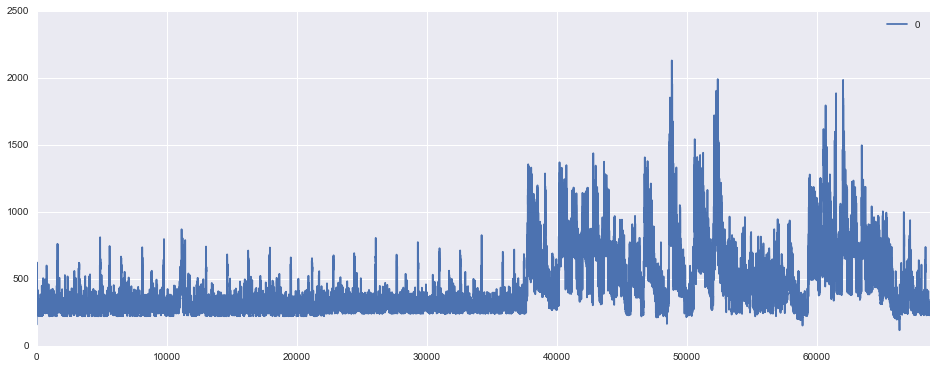

In [217]:
df_r1000 = df.groupby(df.index//1000).mean()
fig = sns.plt.figure(figsize=(16, 6))
ax = sns.plt.subplot()
df_r1000.plot(ax=ax)

Интересные всплески потребления начинаются где-то с 40000-ной миллисекунды (их пять подряд, мы моргали лампочкой пять раз).

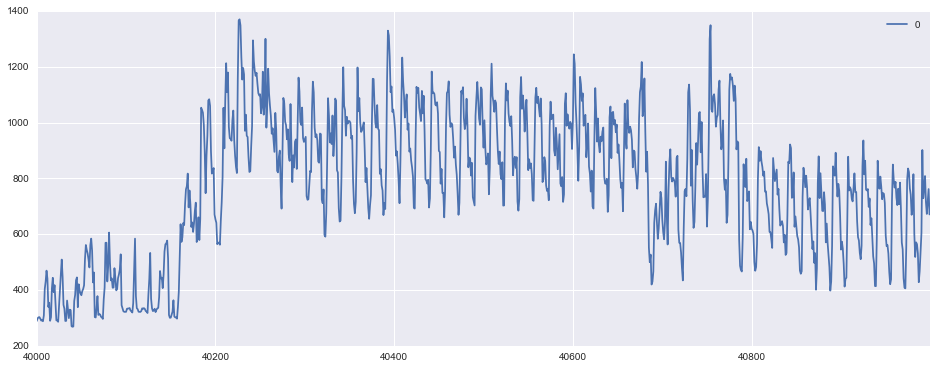

In [219]:
fig = sns.plt.figure(figsize=(16, 6))
ax = sns.plt.subplot()
df_r1000[40000:41000].plot(ax=ax)

Предполагаем, что первый всплеск был в 40200-ю миллисекунду. Теперь посчитаем относительные времена:

In [190]:
times = [
51540,
52010,
52502,
52857,
53317,
53660,
54118,
54504,
54966,
55270,
60000 + 1916,  # PageLoadStarted
60000 + 3453,  # DownloadStarted
60000 + 9147,  # DownloadFinished
60000 + 13336,
60000 + 13691,
60000 + 14051,
60000 + 14377,
60000 + 14783,
60000 + 15089,
60000 + 32190,
60000 + 34015,
60000 + 37349,
60000 + 37491,
]

И построим их на нашем графике:

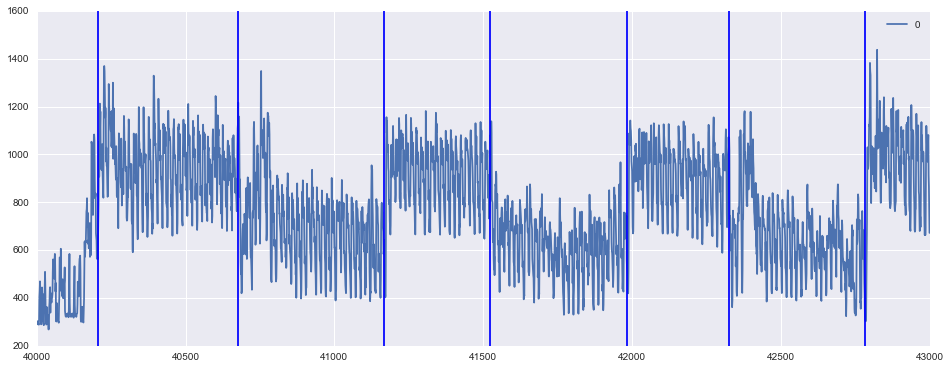

In [223]:
sync = 40200
fig = sns.plt.figure(figsize=(16, 6))
ax = sns.plt.subplot()
sync = 40205
df_r1000[40000:43000].plot(ax=ax)

for t in times:
    sns.plt.axvline(sync + t - times[0])


У второй вспышки более резкий фронт, поэтому попробуем синхронизироваться более точно по нему (и используем микросекундные данные):

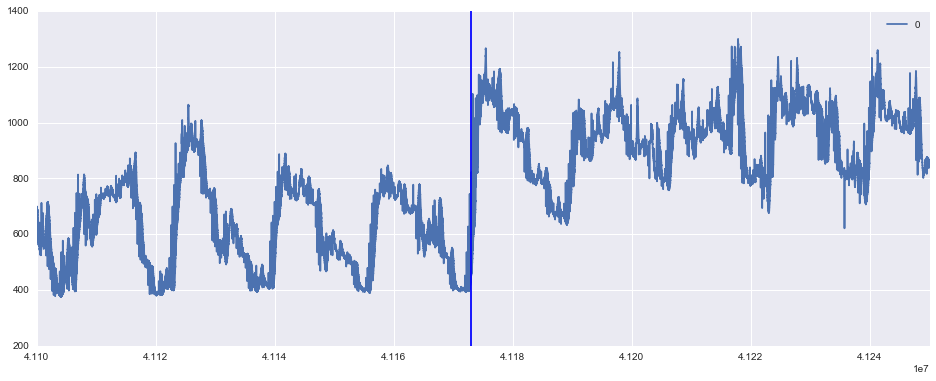

In [226]:
fig = sns.plt.figure(figsize=(16, 6))
ax = sns.plt.subplot()
df[41100000:41250000].plot(ax=ax)
sns.plt.axvline(40200000 +  470000 + 498000 + 5000)

То же для первой вспышки, видно, что фронт у нее размытый:

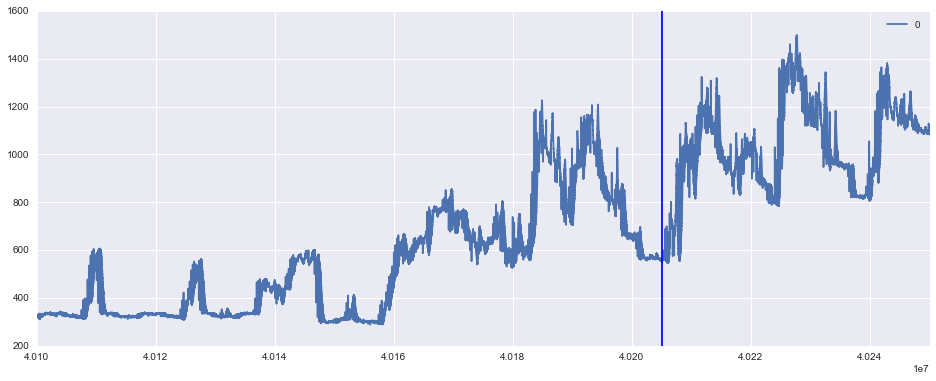

In [227]:
fig = sns.plt.figure(figsize=(16, 6))
ax = sns.plt.subplot()
df[40100000:40250000].plot(ax=ax)
sns.plt.axvline(40200000 + 5000)

Теперь построим данные за весь тесткейс, учитывая изменение синхронизации:

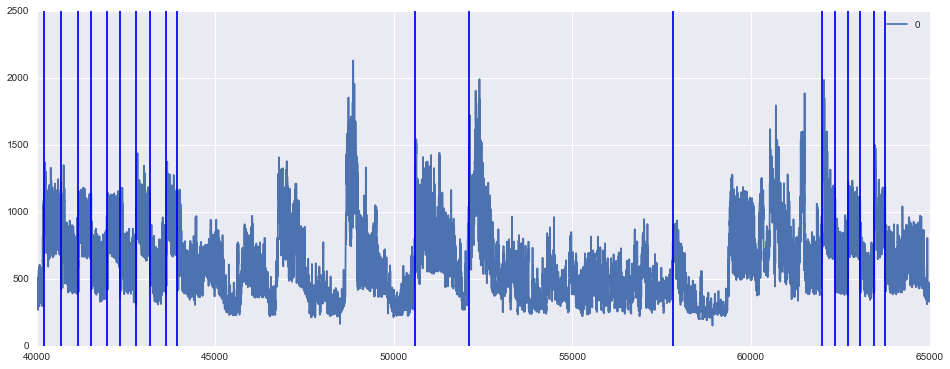

In [228]:
fig = sns.plt.figure(figsize=(16, 6))
ax = sns.plt.subplot()
sync = 40205
df_r1000[40000:65000].plot(ax=ax)

for t in times:
    sns.plt.axvline(sync + t - times[0])

И увеличим до периода загрузки файла:

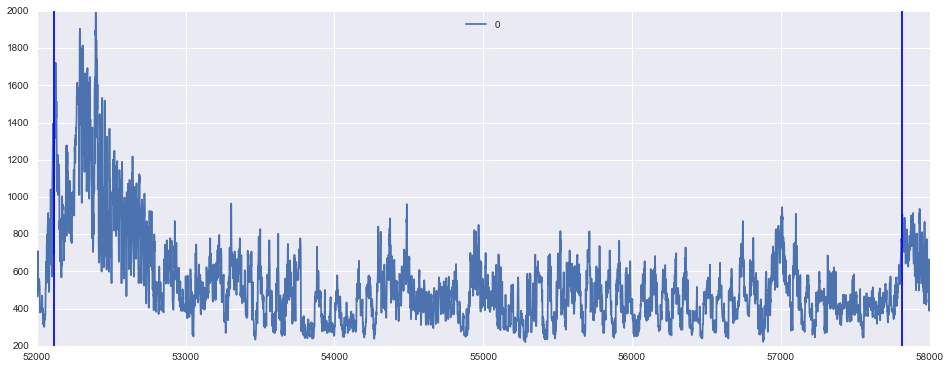

In [229]:
fig = sns.plt.figure(figsize=(16, 6))
ax = sns.plt.subplot()
sync = 40205
df_r1000[52000:58000].plot(ax=ax)

for t in times:
    sns.plt.axvline(sync + t - times[0])

# Фиксим неприятный баг
Можно заметить необычные пики на графике, которые, как будто, предсказывают значение основного тренда:

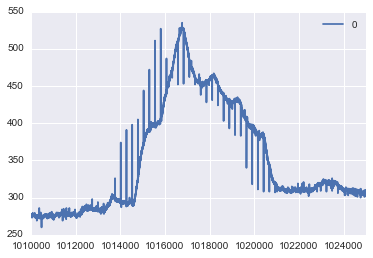

In [79]:
df[1010000:1025000].plot()

Расстояние между пиками -- 256 сэмплов:

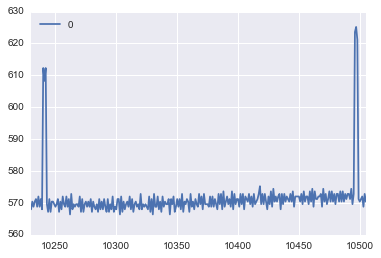

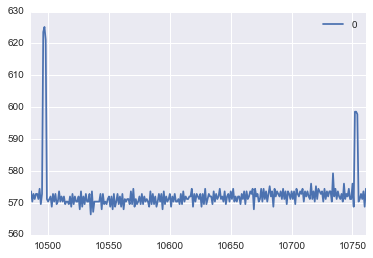

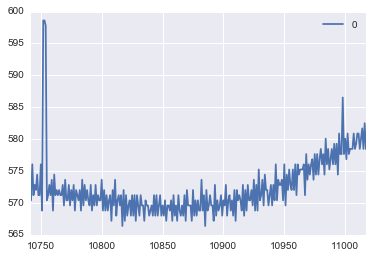

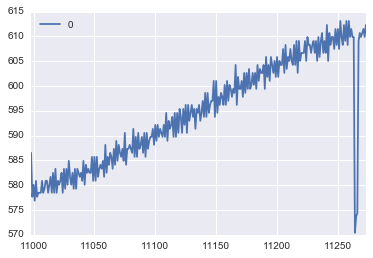

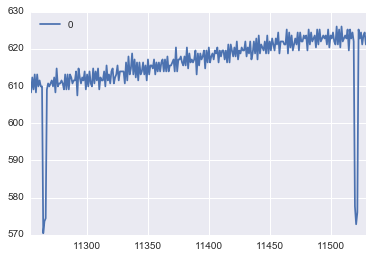

In [238]:
for i in range(5):
    df[10230+256*i:10250+256*(i+1)].plot()

В самом начале -- пустые сэмплы с пиками, по числу буферов. На столько же "предсказывается" значение:

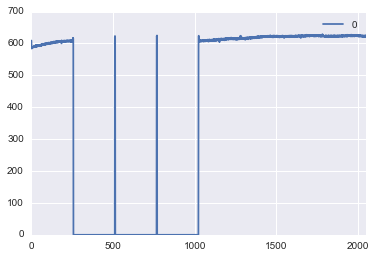

In [239]:
df[:2048].plot()

Оказалось, в исходнике баг, описание тут: https://forum.arduino.cc/index.php?topic=137635.msg2965504#msg2965504
Фиксим, пробуем -- все ок!

In [235]:
df4 = pd.DataFrame(np.fromfile("./output3.bin", dtype=np.uint16).astype(np.float32) * (3300 / 2**12))

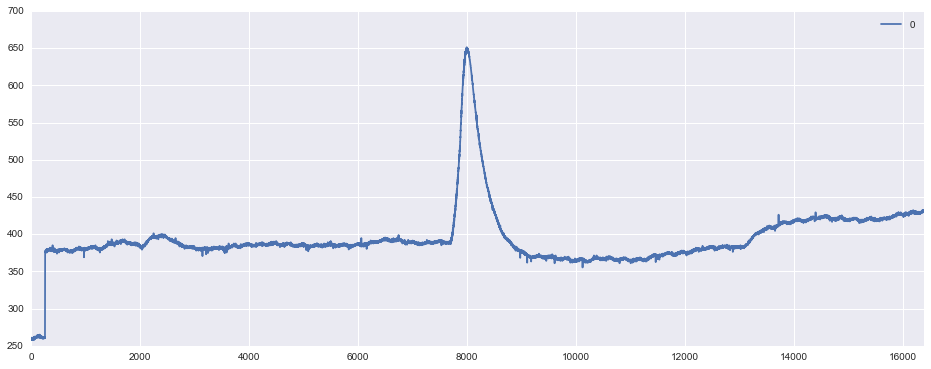

In [236]:
fig = sns.plt.figure(figsize=(16, 6))
ax = sns.plt.subplot()
df4[:16384].plot(ax=ax)

Одна миллисекунда, как мы ее видим:

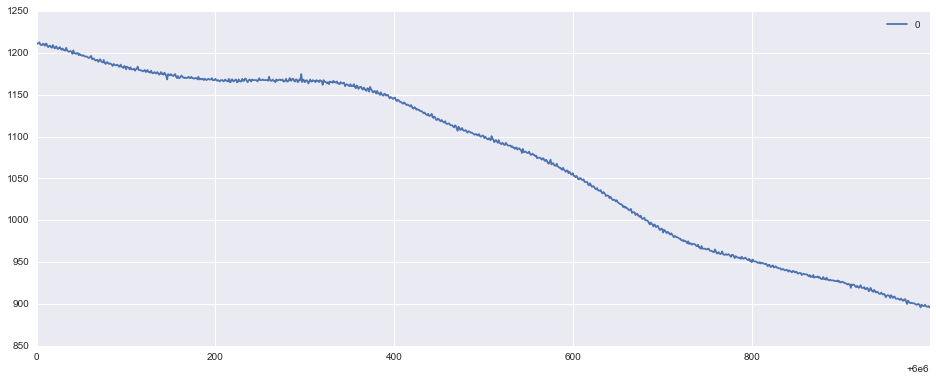

In [237]:
fig = sns.plt.figure(figsize=(16, 6))
ax = sns.plt.subplot()
df4[6000000:6001000].plot(ax=ax)